<a href="https://colab.research.google.com/github/OnyedikachiOnwuachuke/Stock-Price-Prediction-Using-Sentiment-Analysis/blob/main/PREDICTING_TESLA_STOCK_PRICE_USING_SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**IMPORT LIBRARIES**

In [1]:
# Importing necessary libraries
!pip install yfinance
import yfinance as yf
import os
from google.colab import drive
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose

# For Sentiment data analysis
!pip install transformers
import re
import nltk
from nltk.corpus import stopwords
from sklearn.pipeline import make_pipeline
from transformers import pipeline

# For machine learning models
!pip install bayesian-optimization
!pip install keras-tuner
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
import keras_tuner as kt

# For time series models
from statsmodels.tsa.arima.model import ARIMA


# For LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

###**STOCK DATA**

In [2]:
# Loading the stock price data from yahoo finance with the company ticker
TSLA = yf.Ticker("TSLA")
end_date = "2022-09-30"
# All the information about the the comapany ( Tesla Inc.)
TSLA.info

{'address1': '1 Tesla Road',
 'city': 'Austin',
 'state': 'TX',
 'zip': '78725',
 'country': 'United States',
 'phone': '512 516 8177',
 'website': 'https://www.tesla.com',
 'industry': 'Auto Manufacturers',
 'industryKey': 'auto-manufacturers',
 'industryDisp': 'Auto Manufacturers',
 'sector': 'Consumer Cyclical',
 'sectorKey': 'consumer-cyclical',
 'sectorDisp': 'Consumer Cyclical',
 'longBusinessSummary': 'Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. The company operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits; and non-warranty after-sales vehicle, used vehicles, body shop and parts, supercharging, retail merchandise, and vehicle insurance services. This segment also provides sedans and sport utility vehicles through direct and used vehic

In [3]:
# To display, describe and give the necessary information about the stock data
stock_data = TSLA.history(period="max", end=end_date)
stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


In [4]:
# Check the data structure and summary of the stock data
print("Data Info:")
print(stock_data.info())

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3086 entries, 2010-06-29 00:00:00-04:00 to 2022-09-29 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3086 non-null   float64
 1   High          3086 non-null   float64
 2   Low           3086 non-null   float64
 3   Close         3086 non-null   float64
 4   Volume        3086 non-null   int64  
 5   Dividends     3086 non-null   float64
 6   Stock Splits  3086 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 192.9 KB
None


In [5]:
# Display basic statistical details of the stock data
print("\nStatistical Summary:")
print(stock_data.describe())



Statistical Summary:
              Open         High          Low        Close        Volume  \
count  3086.000000  3086.000000  3086.000000  3086.000000  3.086000e+03   
mean     56.092391    57.347290    54.734650    56.075755  9.338840e+07   
std      94.538287    96.712675    92.122923    94.452346  8.232205e+07   
min       1.076000     1.108667     0.998667     1.053333  1.777500e+06   
25%       8.226167     8.375334     7.978500     8.142833  4.172138e+07   
50%      16.000000    16.257999    15.709667    16.008666  7.537575e+07   
75%      23.637500    23.983333    23.313667    23.635166  1.172816e+08   
max     411.470001   414.496674   405.666656   409.970001  9.140820e+08   

       Dividends  Stock Splits  
count     3086.0   3086.000000  
mean         0.0      0.002592  
std          0.0      0.104949  
min          0.0      0.000000  
25%          0.0      0.000000  
50%          0.0      0.000000  
75%          0.0      0.000000  
max          0.0      5.000000  


In [6]:
# Check for missing values on the stock data
print("\nMissing Values:")
print(stock_data.isnull().sum())



Missing Values:
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [7]:
# Display the shape of the stock data
print("\nShape of the Data:")
print(stock_data.shape)


Shape of the Data:
(3086, 7)


In [8]:
#Drop the unnecssary columns for visualisations
stock_data = stock_data.drop(columns=['Volume', 'Dividends', 'Stock Splits'])
stock_data.head()


,Open,High,Low,Close
Date,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000


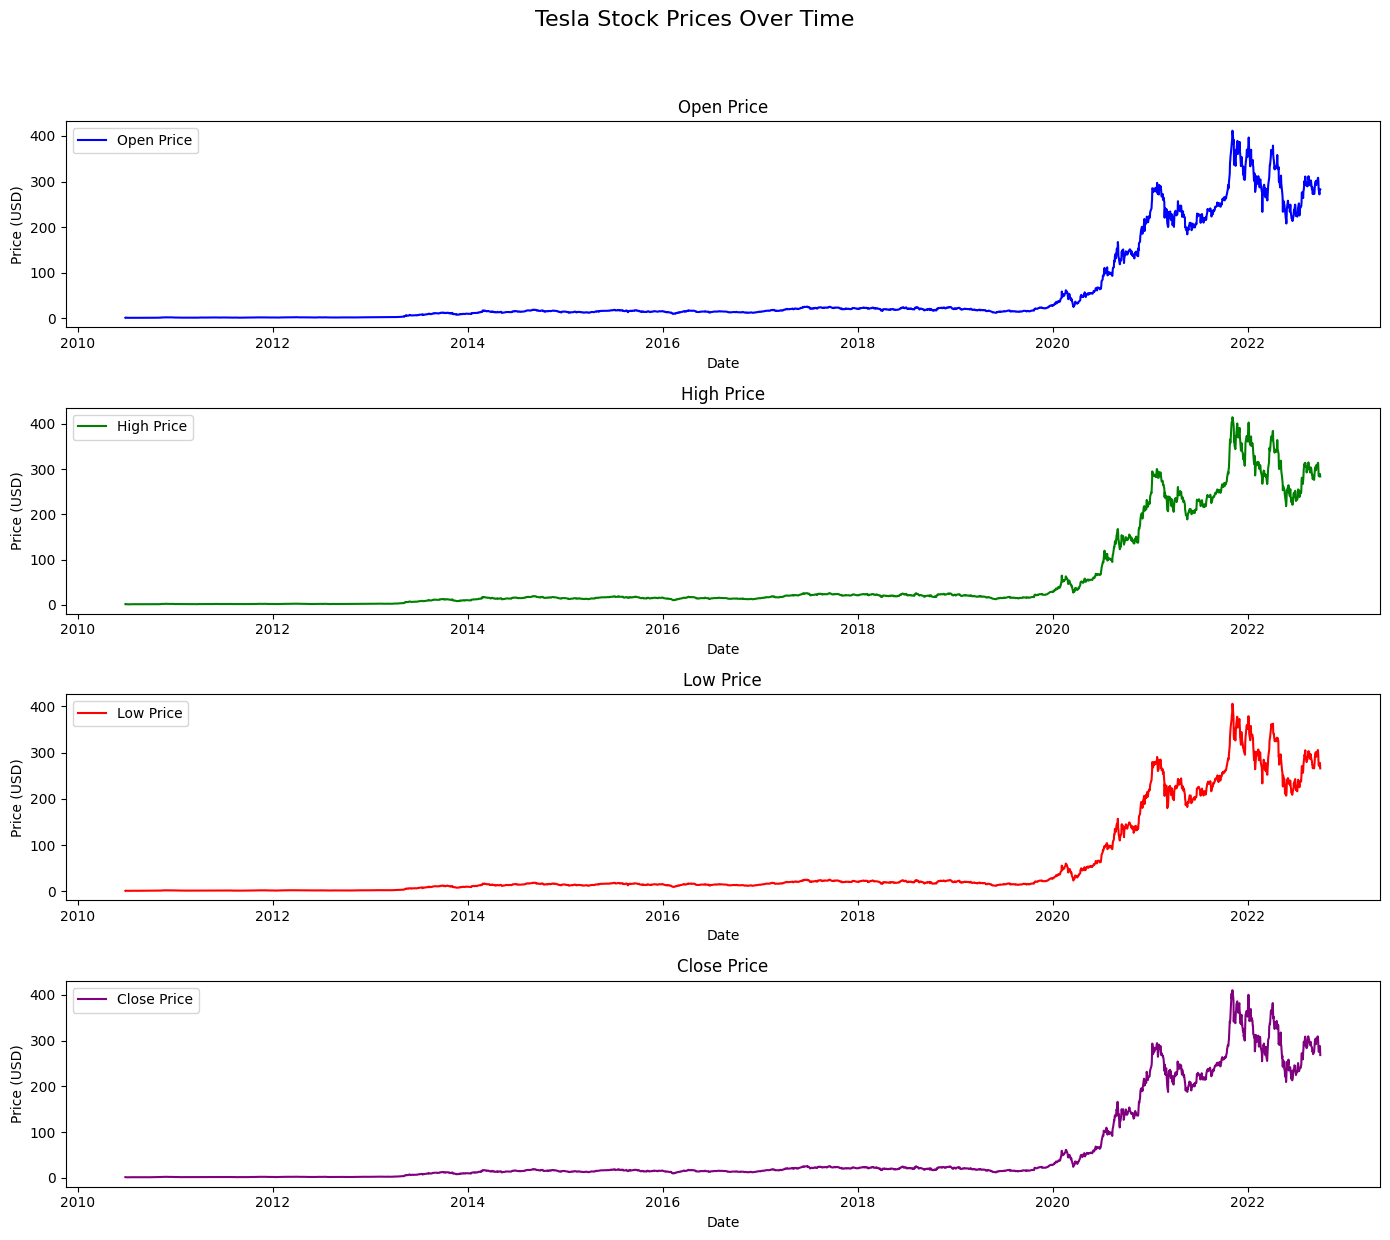

In [9]:
# Creating a 4x1 subplot for Open, High, Low, and Close prices without sharing the x-axis
fig, axs = plt.subplots(4, 1, figsize=(14, 13))
fig.suptitle('Tesla Stock Prices Over Time', fontsize=16)

# Plotting each price type in a separate subplot without shared x-axes
# 1. Open Price
axs[0].plot(stock_data.index, stock_data['Open'], label='Open Price', color='blue')
axs[0].set_title('Open Price')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price (USD)')
axs[0].legend()

# 2. High Price
axs[1].plot(stock_data.index, stock_data['High'], label='High Price',color='green')
axs[1].set_title('High Price')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price (USD)')
axs[1].legend()


# 3. Low Price
axs[2].plot(stock_data.index, stock_data['Low'], label='Low Price', color='red')
axs[2].set_title('Low Price')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price (USD)')
axs[2].legend()

# 4. Close Price
axs[3].plot(stock_data.index, stock_data['Close'], label='Close Price',color='purple')
axs[3].set_title('Close Price')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Price (USD)')
axs[3].legend()

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


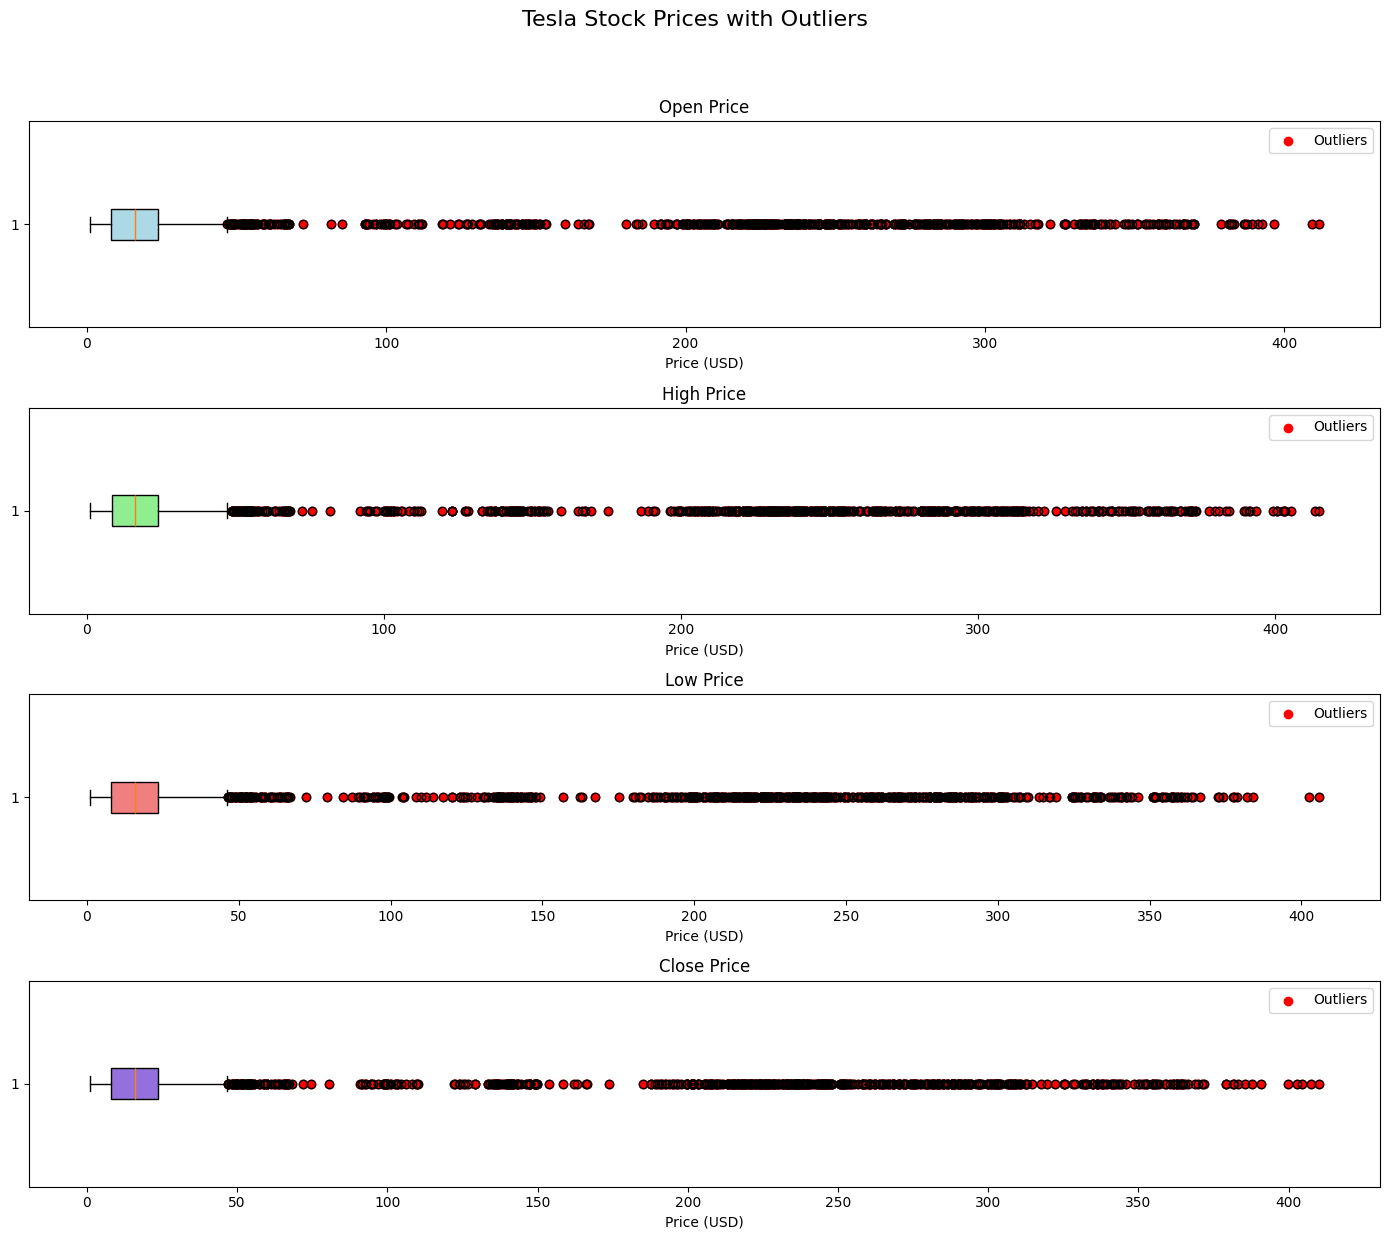

In [10]:
# Using the stock_data DataFrame with 'Open', 'High', 'Low', and 'Close' columns
data_column = stock_data[['Open', 'High', 'Low', 'Close']]

# Create a 4x1 subplot grid
fig, axs = plt.subplots(4, 1, figsize=(14, 13))
fig.suptitle('Tesla Stock Prices with Outliers', fontsize=16)

# Function to calculate outliers and plot boxplot with highlighting
def plot_box_with_outliers(data, ax, label, color):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    # Plot boxplot
    ax.boxplot(data, vert=False, patch_artist=True, boxprops=dict(facecolor=color))
    ax.scatter(outliers, [1] * len(outliers), color='red', label='Outliers', marker='o')

    ax.set_title(label)
    ax.set_xlabel('Price (USD)')
    ax.legend()

# Plot each price type with outliers
plot_box_with_outliers(stock_data['Open'], axs[0], 'Open Price', 'lightblue')
plot_box_with_outliers(stock_data['High'], axs[1], 'High Price', 'lightgreen')
plot_box_with_outliers(stock_data['Low'], axs[2], 'Low Price', 'lightcoral')
plot_box_with_outliers(stock_data['Close'], axs[3], 'Close Price', 'mediumpurple')  # Updated color

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


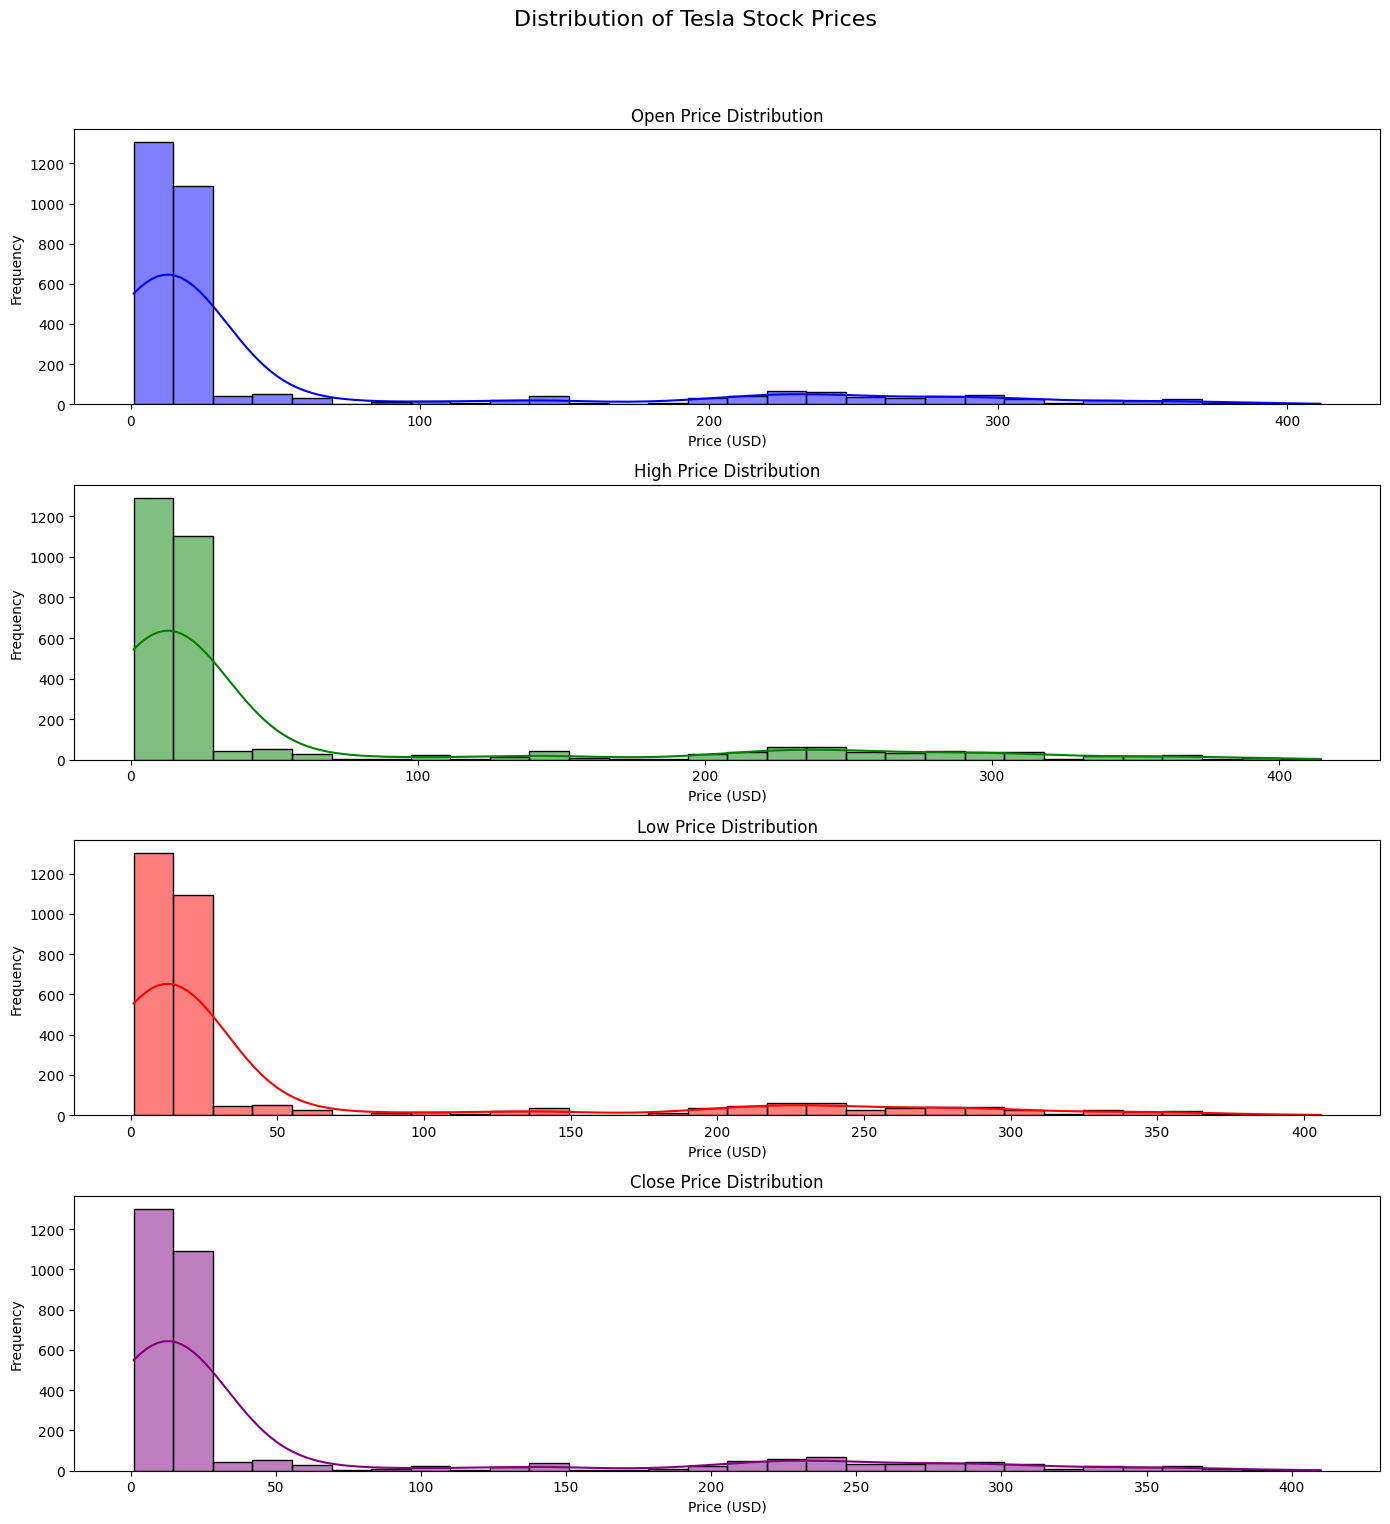

In [11]:
# Creating a 4x1 subplot for Open, High, Low, and Close price distributions
fig, axs = plt.subplots(4, 1, figsize=(14, 16))
fig.suptitle('Distribution of Tesla Stock Prices', fontsize=16)

# Plotting each price type as a histogram
# 1. Open Price Distribution
sns.histplot(stock_data['Open'], bins=30, kde=True, color='blue', ax=axs[0])
axs[0].set_title('Open Price Distribution')
axs[0].set_xlabel('Price (USD)')
axs[0].set_ylabel('Frequency')

# 2. High Price Distribution
sns.histplot(stock_data['High'], bins=30, kde=True, color='green', ax=axs[1])
axs[1].set_title('High Price Distribution')
axs[1].set_xlabel('Price (USD)')
axs[1].set_ylabel('Frequency')

# 3. Low Price Distribution
sns.histplot(stock_data['Low'], bins=30, kde=True, color='red', ax=axs[2])
axs[2].set_title('Low Price Distribution')
axs[2].set_xlabel('Price (USD)')
axs[2].set_ylabel('Frequency')

# 4. Close Price Distribution
sns.histplot(stock_data['Close'], bins=30, kde=True, color='purple', ax=axs[3])
axs[3].set_title('Close Price Distribution')
axs[3].set_xlabel('Price (USD)')
axs[3].set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


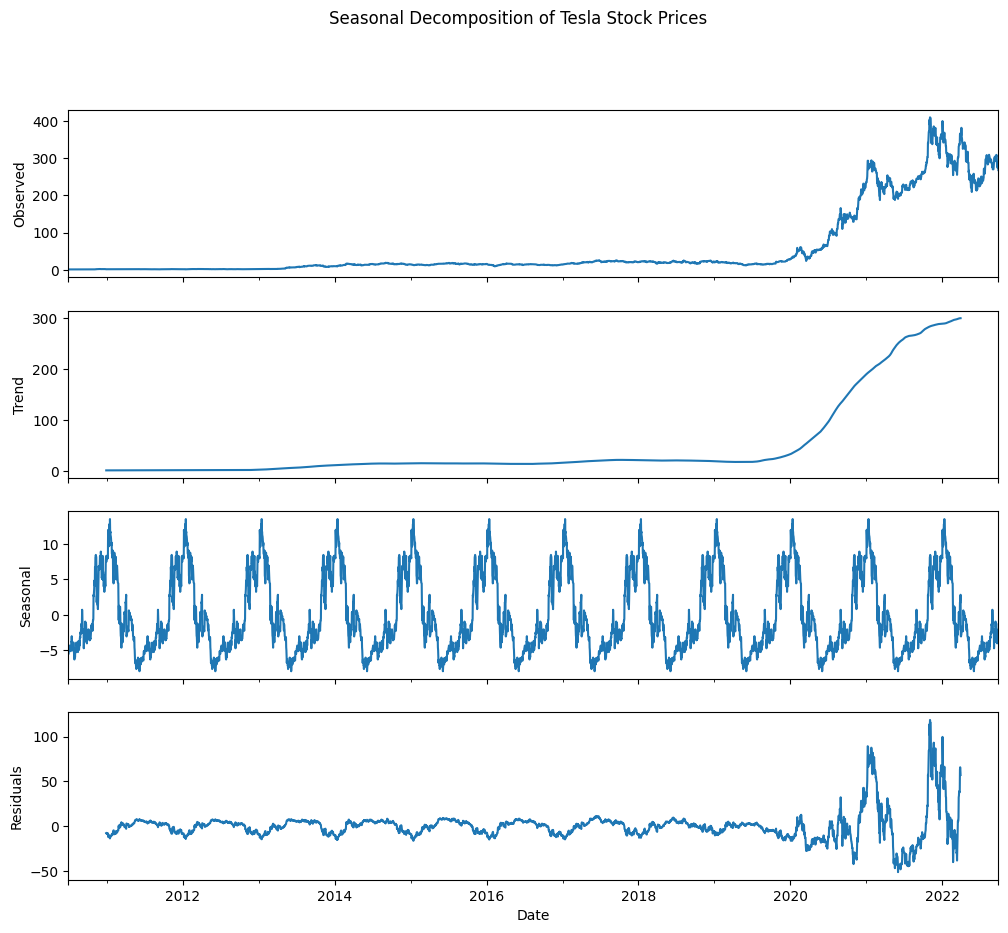

In [12]:
# The stock data is in daily frequency to ensure even time intervals
stock_data_daily = stock_data['Close'].resample('D').ffill()

# Perform seasonal decomposition on the 'Close' prices
decomposition = seasonal_decompose(stock_data_daily, model='additive', period=365)  # period=365 for daily data

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Seasonal Decomposition of Tesla Stock Prices')

decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residuals')
axes[3].set_xlabel('Date')

plt.show()

In [13]:
# Calculate Simple Moving Average (SMA) using the calculate_ma function
def calculate_ma(df, window):
    """
    Calculate the Simple Moving Average (MA/SMA) over a specified window.
    """
    return df['Close'].rolling(window=window).mean()

# Calculate 20-day and 50-day Moving Averages (MAs or SMAs)
stock_data['SMA_20'] = calculate_ma(stock_data, window=20)
stock_data['SMA_50'] = calculate_ma(stock_data, window=50)

# Exponential Moving Average (EMA)
def calculate_ema(df, span):
    """
    Calculate the Exponential Moving Average (EMA).
    """
    return df['Close'].ewm(span=span, adjust=False).mean()

# Calculate EMA 50 and EMA 200
stock_data['EMA_50'] = calculate_ema(stock_data, span=50)
stock_data['EMA_200'] = calculate_ema(stock_data, span=200)

# Moving Average Convergence/Divergence (MACD)
def calculate_macd(df, short_span=12, long_span=26, signal_span=9):
    """
    Calculate the MACD, Signal Line, and MACD Histogram.
    """
    short_ema = df['Close'].ewm(span=short_span, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_span, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_span, adjust=False).mean()
    macd_histogram = macd - signal
    return pd.DataFrame({'MACD': macd, 'Signal': signal, 'MACD_Histogram': macd_histogram})

# Calculate MACD, Signal Line, and MACD Histogram
macd_df = calculate_macd(stock_data)

# Add MACD components to the DataFrame
stock_data['MACD'] = macd_df['MACD']
stock_data['MACD_Signal'] = macd_df['Signal']
stock_data['MACD_Histogram'] = macd_df['MACD_Histogram']

# Relative Strength Index (RSI)
def calculate_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI
stock_data['RSI'] = calculate_rsi(stock_data)

# Average Directional Index (ADX)
def calculate_adx(df, window=14):
    high = df['High']
    low = df['Low']
    close = df['Close']

    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    atr = tr.rolling(window=window, min_periods=1).mean()
    plus_di = 100 * (plus_dm.ewm(alpha=1/window).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/window).mean() / atr))

    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.ewm(alpha=1/window).mean()

    return pd.DataFrame({'ADX': adx, 'Plus_DI': plus_di, 'Minus_DI': minus_di})

# Calculate ADX, Plus_DI, and Minus_DI
adx_df = calculate_adx(stock_data)

# Add ADX components to the DataFrame
stock_data['ADX'] = adx_df['ADX']
stock_data['Plus_DI'] = adx_df['Plus_DI']
stock_data['Minus_DI'] = adx_df['Minus_DI']

# Drop rows with NaN values at the beginning of the dataset (if any)
stock_data.dropna(inplace=True)

# Display the first few rows of the updated DataFrame
stock_data.head()



,Open,High,Low,Close,SMA_20,SMA_50,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
Date,,,,,,,,,,,,,,,
2010-09-08 00:00:00-04:00,1.377333,1.396667,1.373333,1.393333,1.301467,1.322240,1.361035,1.486359,0.013624,-0.001767,0.015391,67.149673,15.148664,32.092516,19.425309
2010-09-09 00:00:00-04:00,1.400000,1.403333,1.379333,1.380667,1.310833,1.318000,1.361805,1.485307,0.015075,0.001602,0.013474,65.047002,15.941895,32.222275,18.931977
2010-09-10 00:00:00-04:00,1.383333,1.395333,1.317333,1.344667,1.319400,1.313120,1.361133,1.483908,0.013169,0.003915,0.009254,58.093849,15.238047,28.376171,25.006138
2010-09-13 00:00:00-04:00,1.392667,1.393333,1.366667,1.381333,1.327400,1.311467,1.361925,1.482887,0.014450,0.006022,0.008428,54.812352,14.586735,27.918925,24.603195
2010-09-14 00:00:00-04:00,1.369333,1.440000,1.368667,1.408000,1.335200,1.314027,1.363732,1.482142,0.017416,0.008301,0.009115,67.142833,14.802616,32.856891,23.046153


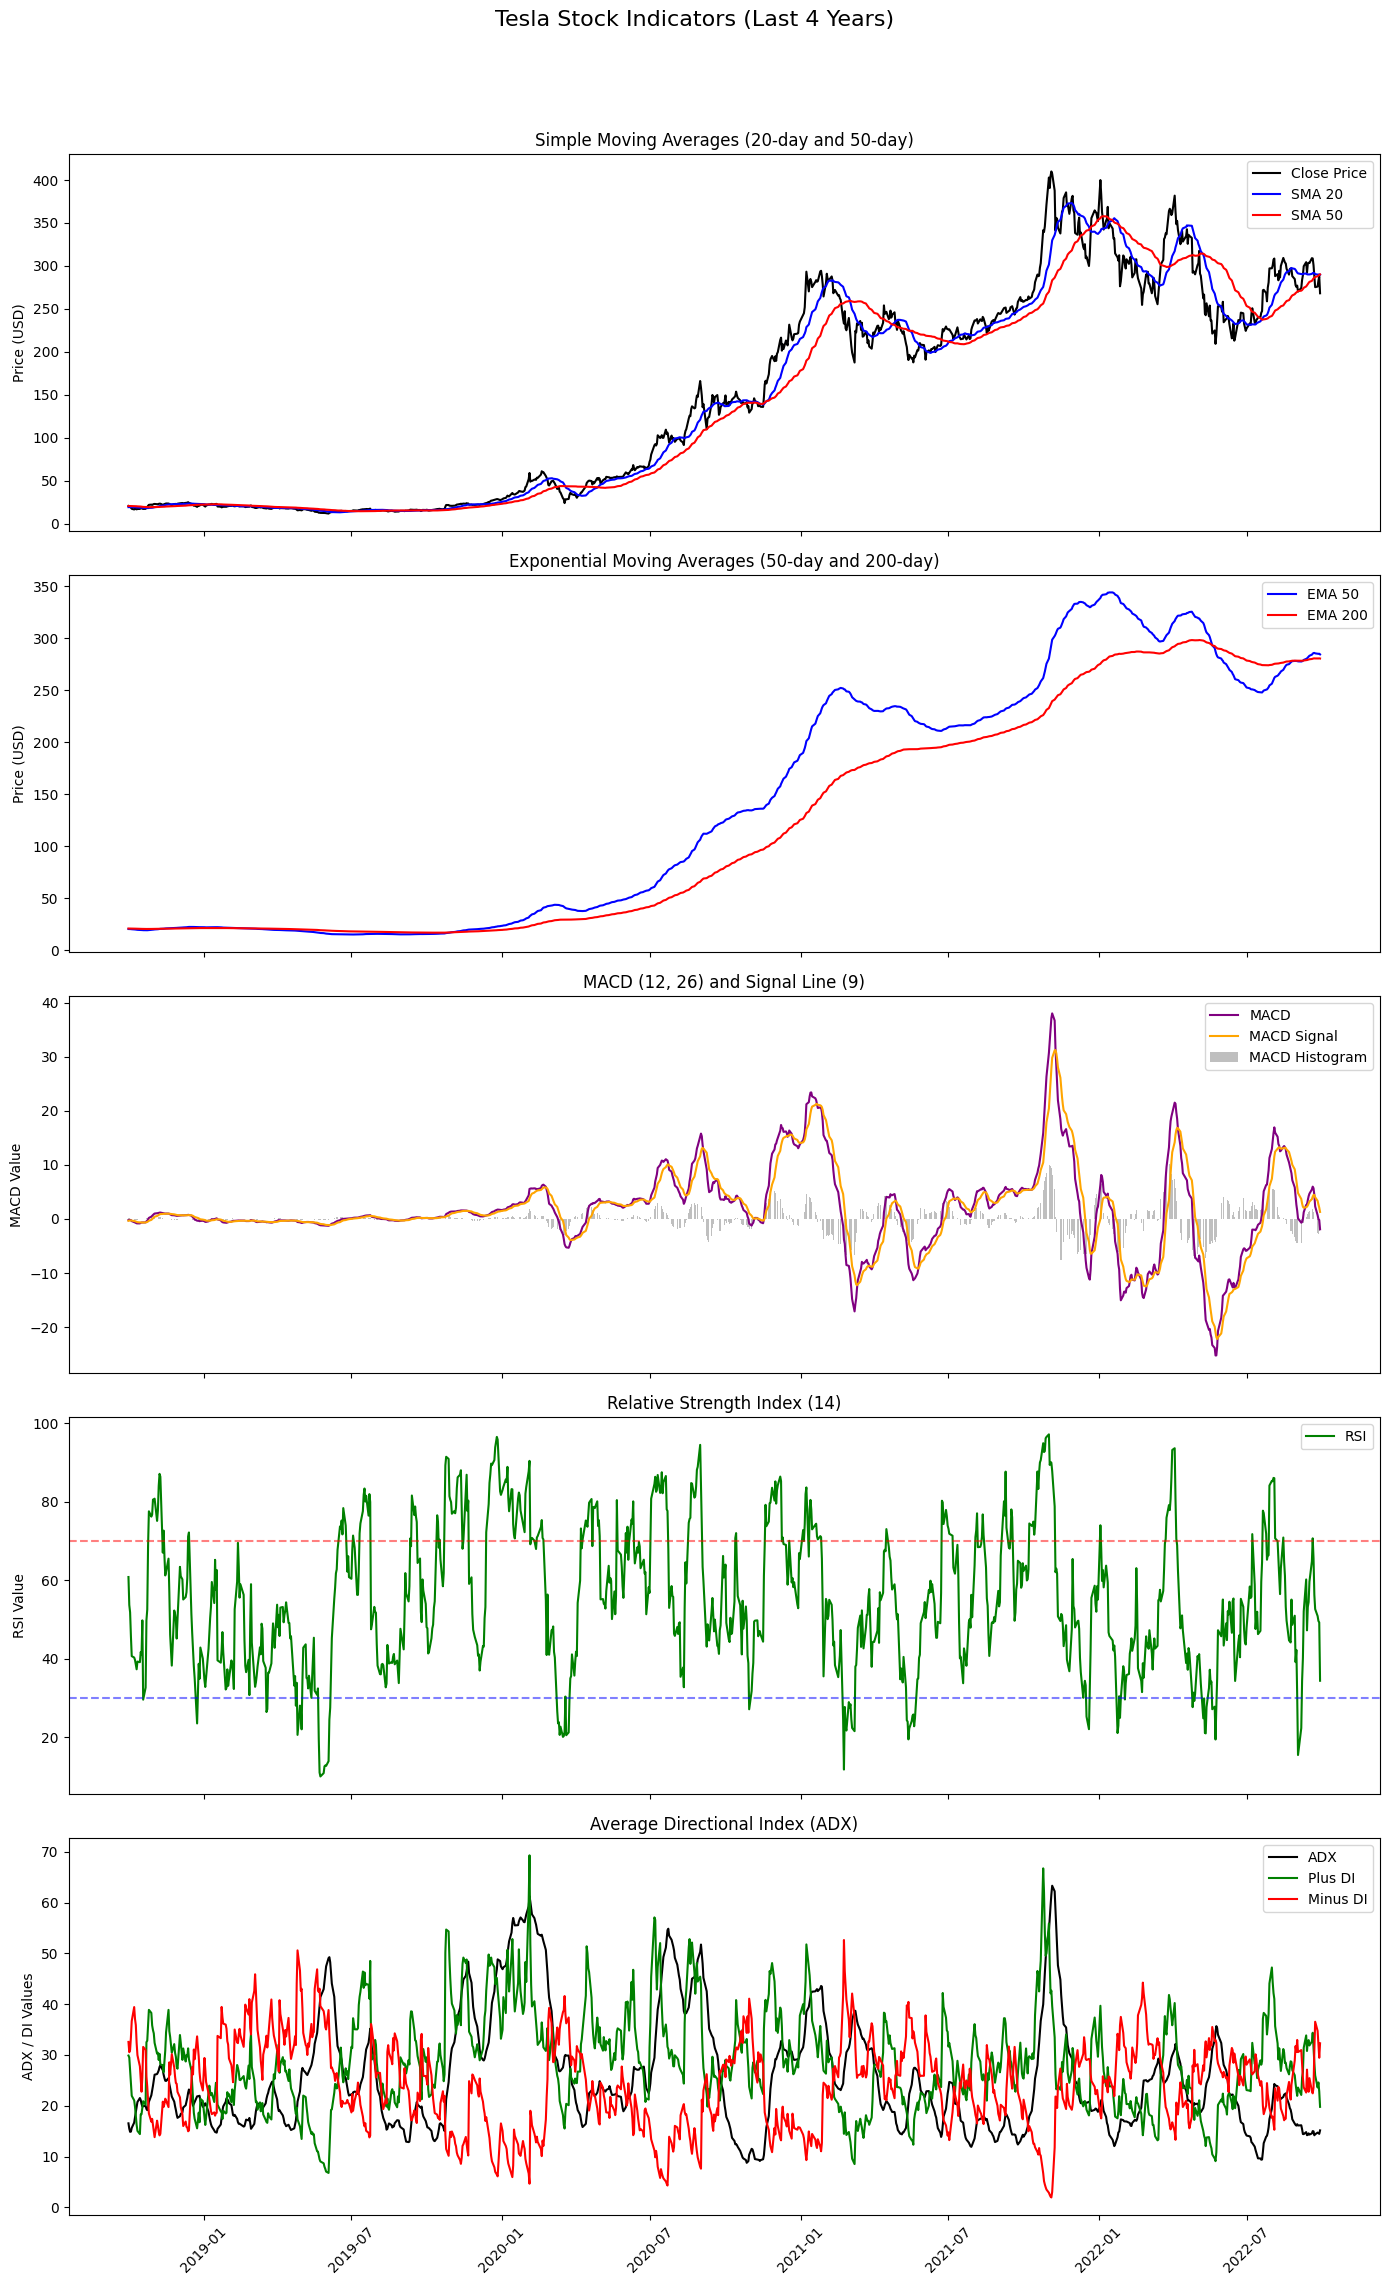

In [14]:
# Filtering the data for the last four years for visualising the necessary indicators
four_years_ago = stock_data.index.max() - timedelta(days=4*365)
filtered_data = stock_data[stock_data.index >= four_years_ago]

# Plot the indicators for the filtered data
fig, axs = plt.subplots(5, 1, figsize=(14, 24), sharex=True)
fig.suptitle('Tesla Stock Indicators (Last 4 Years)', fontsize=16)

# Plot SMAs and Closing Price
axs[0].plot(filtered_data.index, filtered_data['Close'], label='Close Price', color='black')
axs[0].plot(filtered_data.index, filtered_data['SMA_20'], label='SMA 20', color='blue')
axs[0].plot(filtered_data.index, filtered_data['SMA_50'], label='SMA 50', color='red')
axs[0].set_ylabel('Price (USD)')
axs[0].set_title('Simple Moving Averages (20-day and 50-day)')
axs[0].legend()

# Plot EMAs
axs[1].plot(filtered_data.index, filtered_data['EMA_50'], label='EMA 50', color='blue')
axs[1].plot(filtered_data.index, filtered_data['EMA_200'], label='EMA 200', color='red')
axs[1].set_ylabel('Price (USD)')
axs[1].set_title('Exponential Moving Averages (50-day and 200-day)')
axs[1].legend()

# Plot MACD
axs[2].plot(filtered_data.index, filtered_data['MACD'], label='MACD', color='purple')
axs[2].plot(filtered_data.index, filtered_data['MACD_Signal'], label='MACD Signal', color='orange')
axs[2].bar(filtered_data.index, filtered_data['MACD_Histogram'], label='MACD Histogram', color='grey', alpha=0.5)
axs[2].set_ylabel('MACD Value')
axs[2].set_title('MACD (12, 26) and Signal Line (9)')
axs[2].legend()

# Plot RSI
axs[3].plot(filtered_data.index, filtered_data['RSI'], label='RSI', color='green')
axs[3].axhline(70, linestyle='--', color='red', alpha=0.5)
axs[3].axhline(30, linestyle='--', color='blue', alpha=0.5)
axs[3].set_ylabel('RSI Value')
axs[3].set_title('Relative Strength Index (14)')
axs[3].legend()

# Plot ADX
axs[4].plot(filtered_data.index, filtered_data['ADX'], label='ADX', color='black')
axs[4].plot(filtered_data.index, filtered_data['Plus_DI'], label='Plus DI', color='green')
axs[4].plot(filtered_data.index, filtered_data['Minus_DI'], label='Minus DI', color='red')
axs[4].set_ylabel('ADX / DI Values')
axs[4].set_title('Average Directional Index (ADX)')
axs[4].legend()

plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


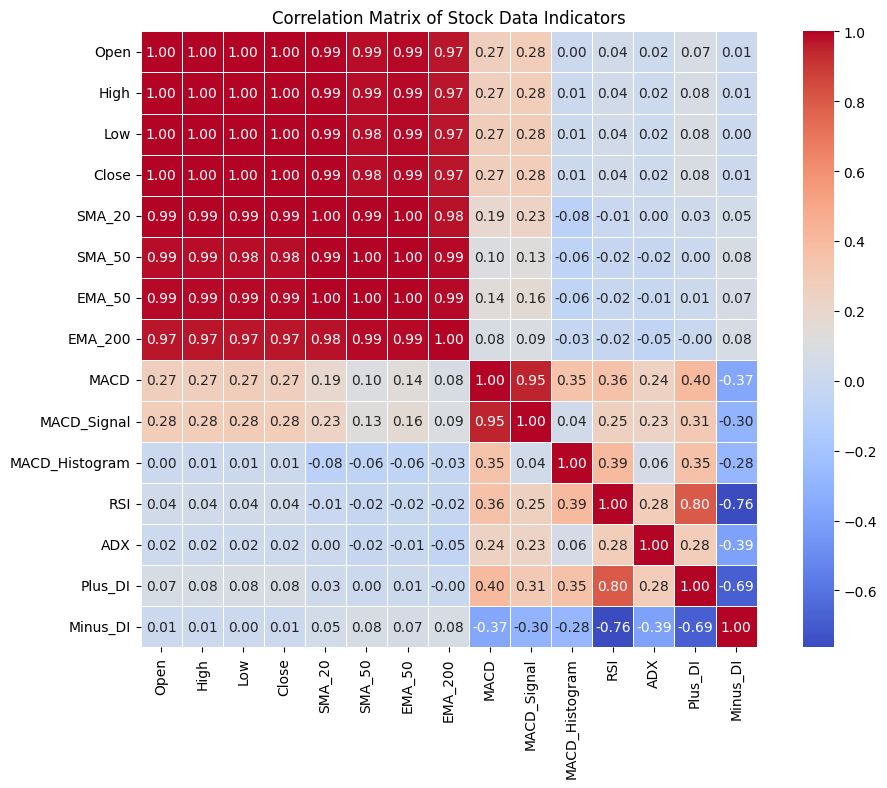

In [15]:
# Visualising the correlation matrix for the stock data
correlation_matrix = stock_data.corr()

# Set up thefigure size
plt.figure(figsize=(12, 8))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True,
            linewidths=.5, annot_kws={"size": 10})
plt.title('Correlation Matrix of Stock Data Indicators')
plt.show()


**STOCK DATA PREPROCESSING**


In [16]:
# Preprocessing function for stock data
def preprocess_stock_data(data, start_date, end_date):
    """
    Preprocess stock data for the given date range and prepare it for training.

    Parameters:
        data (pd.DataFrame): The stock data with 'Date' as an index and columns ['Open', 'High', 'Low', 'Close', 'Volume', ...].
        start_date (str): Start date in the format 'YYYY-MM-DD'.
        end_date (str): End date in the format 'YYYY-MM-DD'.

    Returns:
        X_train, X_test, y_train, y_test: Training and testing datasets.
        scaler_y: Scaler for the target variable.
    """

    # Filter data within the specified date range
    filtered_data = data.loc[start_date:end_date]

    # Handle missing values (drop rows with NaNs)
    filtered_data = filtered_data.dropna()

    # Define the features and target variable
    feature_columns = [col for col in filtered_data.columns if col not in ['Date', 'Close']]
    target_column = 'Close'

    # Select features and target
    features = filtered_data[feature_columns]
    target = filtered_data[target_column]

    # Normalize features using MinMaxScaler
    scaler_X = MinMaxScaler()
    features_scaled = scaler_X.fit_transform(features)

    # Normalize target using MinMaxScaler
    # Initialize MinMaxScaler for the target variable (y)
    scaler_y = MinMaxScaler()
    target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

    # Split into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, shuffle=False)



    return X_train, X_test, y_train, y_test, scaler_X, scaler_y
X_train, X_test, y_train, y_test, scaler_X, scaler_y = preprocess_stock_data(stock_data, start_date='2021-09-30', end_date='2022-09-30')
# Displaying the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

filtered_data.head()


X_train shape: (201, 14)
X_test shape: (51, 14)
y_train shape: (201, 1)
y_test shape: (51, 1)


,Open,High,Low,Close,SMA_20,SMA_50,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
Date,,,,,,,,,,,,,,,
2018-10-01 00:00:00-04:00,20.384666,20.762667,20.070000,20.713333,19.411700,20.723933,20.391357,20.886165,-0.206465,-0.331736,0.125271,60.786743,16.544206,29.889921,32.572710
2018-10-02 00:00:00-04:00,20.930000,21.122667,19.943333,20.068001,19.451933,20.721027,20.378676,20.878024,-0.168661,-0.299121,0.130460,53.652080,15.486103,29.504991,30.544296
2018-10-03 00:00:00-04:00,20.222000,20.306667,19.438000,19.653334,19.498800,20.717520,20.350231,20.865838,-0.170199,-0.273337,0.103138,51.796532,14.868813,27.046929,31.021133
2018-10-04 00:00:00-04:00,19.596666,19.600000,18.511333,18.788668,19.501733,20.681640,20.288993,20.845169,-0.238441,-0.266358,0.027917,45.710623,14.915649,24.497848,33.502057
2018-10-05 00:00:00-04:00,18.309999,18.325333,17.333332,17.463333,19.497433,20.622040,20.178183,20.811519,-0.394915,-0.292069,-0.102845,40.622684,15.641794,21.971450,36.682955


****MODEL SELECTION AND TRAINING ON THE STOCK DATA****

**Model 1**: Linear Regression (Traditional Machine Learning Model)
Linear Regression is a simple, interpretable model, useful for modeling trends in stock data.

Train Root Mean Squared Error (RMSE): 4.00
Test  Root Mean Squared Error (RMSE): 4.60
Train R² Score: 0.99
Test  R² Score: 0.89


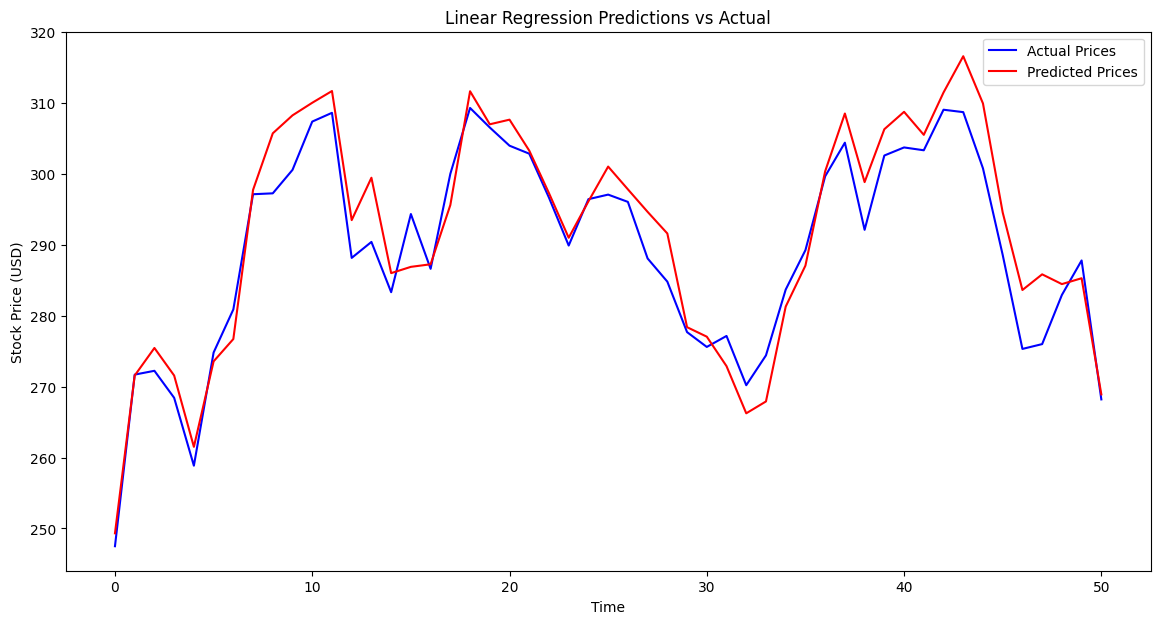

In [17]:
# Train a Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the train and test sets
linear_train_pred = linear_model.predict(X_train)
linear_test_pred = linear_model.predict(X_test)

# Convert y_train and y_test to NumPy arrays before reshaping
linear_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))  # Reshaping to 2D for inverse_transform
linear_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))    # Reshaping to 2D for inverse_transform
linear_train_pred_actual = scaler_y.inverse_transform(linear_train_pred.reshape(-1, 1))
linear_test_pred_actual = scaler_y.inverse_transform(linear_test_pred.reshape(-1, 1))

# Evaluate the model using RMSE
linear_train_rmse = np.sqrt(mean_squared_error(linear_train_actual, linear_train_pred_actual))
linear_test_rmse = np.sqrt(mean_squared_error(linear_test_actual, linear_test_pred_actual))

# Evaluate the model using R² score
linear_train_r2 = r2_score(linear_train_actual, linear_train_pred_actual)
linear_test_r2 = r2_score(linear_test_actual, linear_test_pred_actual)

print(f"Train Root Mean Squared Error (RMSE): {linear_train_rmse:.2f}")
print(f"Test  Root Mean Squared Error (RMSE): {linear_test_rmse:.2f}")
print(f"Train R² Score: {linear_train_r2 :.2f}")
print(f"Test  R² Score: {linear_test_r2:.2f}")

# Visualizing predictions vs actual values for the test set
plt.figure(figsize=(14, 7))
plt.plot(linear_test_actual, label='Actual Prices', color='blue')
plt.plot(linear_test_pred_actual, label='Predicted Prices', color='red')
plt.title('Linear Regression Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


In [18]:
# Build and train XGB model
def build_and_train_xgb_model(X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb):
    """
    Build and train an XGBoost model and evaluate its performance.

    Parameters:
    X_train_xgb (np.ndarray): Training data for features.
    y_train_xgb (np.ndarray): Training data for the target variable.
    X_test_xgb (np.ndarray): Test data for features.
    y_test_xgb (np.ndarray): Test data for the target variable.

    Returns:
    xgb_model (XGBRegressor): Trained XGBoost model.
    """
    # Initialize the XGBoost model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

    # Train the model
    xgb_model.fit(
        X_train_xgb,
        y_train_xgb.ravel(),
        eval_set=[(X_test_xgb, y_test_xgb)],
        verbose=True
    )

    return xgb_model

[0]	validation_0-rmse:0.08688
[1]	validation_0-rmse:0.07855
[2]	validation_0-rmse:0.07119
[3]	validation_0-rmse:0.06617
[4]	validation_0-rmse:0.06070
[5]	validation_0-rmse:0.05575
[6]	validation_0-rmse:0.05210
[7]	validation_0-rmse:0.04914
[8]	validation_0-rmse:0.04613
[9]	validation_0-rmse:0.04276
[10]	validation_0-rmse:0.04024
[11]	validation_0-rmse:0.03781
[12]	validation_0-rmse:0.03570
[13]	validation_0-rmse:0.03392
[14]	validation_0-rmse:0.03235
[15]	validation_0-rmse:0.03090
[16]	validation_0-rmse:0.02938
[17]	validation_0-rmse:0.02854
[18]	validation_0-rmse:0.02765
[19]	validation_0-rmse:0.02726
[20]	validation_0-rmse:0.02713
[21]	validation_0-rmse:0.02667
[22]	validation_0-rmse:0.02666
[23]	validation_0-rmse:0.02636
[24]	validation_0-rmse:0.02629
[25]	validation_0-rmse:0.02611
[26]	validation_0-rmse:0.02606
[27]	validation_0-rmse:0.02594
[28]	validation_0-rmse:0.02585
[29]	validation_0-rmse:0.02578
[30]	validation_0-rmse:0.02580
[31]	validation_0-rmse:0.02566
[32]	validation_0-

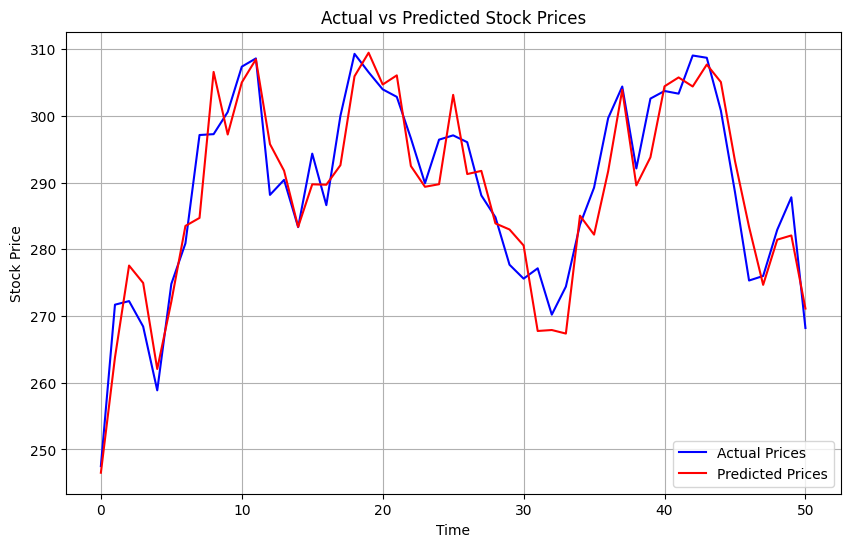

In [19]:
from sklearn.metrics import r2_score

# Make predictions and evaluate performance
def predict_and_evaluate_xgb(xgb_model, X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb, scaler_y):
    """
    Make predictions using the trained XGBoost model and evaluate the performance.

    Parameters:
    xgb_model (XGBRegressor): Trained XGBoost model.
    X_train (np.ndarray): Training data for features.
    y_train (np.ndarray): Training data for target variable.
    X_test (np.ndarray): Test data for features.
    y_test (np.ndarray): Test data for target variable.
    scaler_y (MinMaxScaler): Scaler used for the target variable.

    Returns:
    dict: A dictionary containing evaluation metrics (RMSE, R²) for both train and test sets, and actual vs predicted values.
    """
    # Predict on the train and test sets
    xgb_train_pred_scaled = xgb_model.predict(X_train)
    xgb_test_pred_scaled = xgb_model.predict(X_test)

    # Inverse transform the predictions and target to original scale
    xgb_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    xgb_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    xgb_train_pred_actual = scaler_y.inverse_transform(xgb_train_pred_scaled.reshape(-1, 1))
    xgb_test_pred_actual = scaler_y.inverse_transform(xgb_test_pred_scaled.reshape(-1, 1))

    # Calculate RMSE and R² for train and test sets
    xgb_train_rmse = np.sqrt(mean_squared_error(xgb_train_actual, xgb_train_pred_actual))
    xgb_test_rmse = np.sqrt(mean_squared_error(xgb_test_actual, xgb_test_pred_actual))
    xgb_train_r2 = r2_score(xgb_train_actual, xgb_train_pred_actual)
    xgb_test_r2 = r2_score(xgb_test_actual, xgb_test_pred_actual)

    print(f"Train Root Mean Squared Error (RMSE): {xgb_train_rmse:.2f}")
    print(f"Test  Root Mean Squared Error (RMSE): {xgb_test_rmse:.2f}")
    print(f"Train R² Score: {xgb_train_r2:.2f}")
    print(f"Test  R² Score: {xgb_test_r2:.2f}")

    return {
        'Train_RMSE': xgb_train_rmse,
        'Test_RMSE': xgb_test_rmse,
        'Train_R2': xgb_train_r2,
        'Test_R2': xgb_test_r2,
        'y_test_actual': xgb_test_actual,
        'y_test_pred_actual': xgb_test_pred_actual
    }

# Train the XGBoost model
xgb_model = build_and_train_xgb_model(X_train, y_train, X_test, y_test)

# Predict and evaluate
xgb_results = predict_and_evaluate_xgb(xgb_model, X_train, y_train, X_test, y_test, scaler_y)

# Extract metrics and actual/predicted values
xgb_test_actual = xgb_results['y_test_actual']
xgb_test_pred_actual = xgb_results['y_test_pred_actual']

# Display actual vs predicted
comparison_df = pd.DataFrame({'Actual': xgb_test_actual.ravel(), 'Predicted': xgb_test_pred_actual.ravel()})
print("\nActual vs Predicted:")
print(comparison_df.head())

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(xgb_test_actual, label='Actual Prices', color='blue')
plt.plot(xgb_test_pred_actual, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()



In [20]:
# Preprocessing function of the stock data for the LSTM model
def preprocess_stock_data_lstm(data, feature_columns, target_column, look_back=60):
    """
    Prepare data for LSTM model by creating sequences.

    Parameters:
        data (pd.DataFrame): Stock data with features and target column.
        feature_columns (list): Columns used as features.
        target_column (str): Column to be predicted.
        look_back (int): Number of past time steps to use as input.

    Returns:
        X, y: Features and target arrays for training/testing.
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[feature_columns + [target_column]])

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i - look_back:i, :-1])  # Features (all except target)
        y.append(scaled_data[i, -1])  # Target (last column)
    return np.array(X), np.array(y), scaler


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 0.0029 - val_loss: 0.0623
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 2.3424e-04 - val_loss: 0.0615
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 1.3900e-04 - val_loss: 0.0378
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 9.6363e-05 - val_loss: 0.0207
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 7.3997e-05 - val_loss: 0.0213
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 6.3924e-05 - val_loss: 0.0113
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 6.5538e-05 - val_loss: 0.0111
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 4.7986e-05 - val_loss: 0.0097
Epoch 9/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 4.9029e-05 - val_loss: 0.0057
Epoch 10/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 4.7023e-05 - val_loss: 0.0052
Epoch 11/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 3.7094e-05 - val_loss: 0.0049
Epoch 

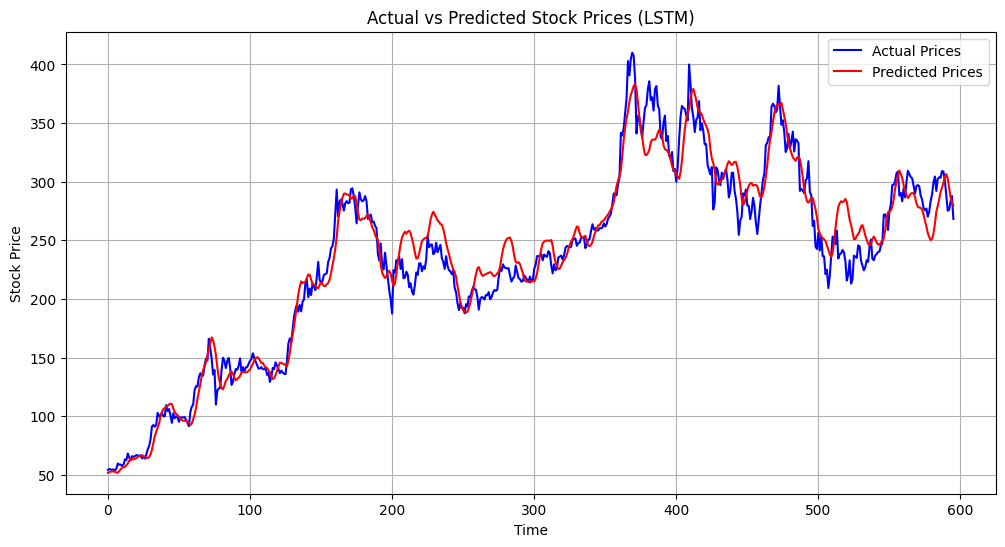

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define LSTM model
def build_lstm_model(input_shape):
    """
    Build and compile an LSTM model.

    Parameters:
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        model: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Prepare data
look_back = 60
feature_columns = [col for col in filtered_data.columns if col not in ['Date', 'Close']]
target_column = 'Close'
X, y, scaler = preprocess_stock_data_lstm(stock_data, feature_columns, target_column, look_back=look_back)

# Split into train/test sets (80/20)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build and train LSTM model
lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
history = lstm_model.fit(
    X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1
)

# Predictions
lstm_train_pred_scaled = lstm_model.predict(X_train)
lstm_test_pred_scaled = lstm_model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
lstm_train_actual = scaler.inverse_transform(
    np.hstack((np.zeros((y_train.shape[0], len(feature_columns))), y_train.reshape(-1, 1)))
)[:, -1]
lstm_test_actual = scaler.inverse_transform(
    np.hstack((np.zeros((y_test.shape[0], len(feature_columns))), y_test.reshape(-1, 1)))
)[:, -1]
lstm_train_pred_actual = scaler.inverse_transform(
    np.hstack((np.zeros((lstm_train_pred_scaled.shape[0], len(feature_columns))), lstm_train_pred_scaled))
)[:, -1]
lstm_test_pred_actual = scaler.inverse_transform(
    np.hstack((np.zeros((lstm_test_pred_scaled.shape[0], len(feature_columns))), lstm_test_pred_scaled))
)[:, -1]

# Evaluation metrics
lstm_train_rmse = np.sqrt(mean_squared_error(lstm_train_actual, lstm_train_pred_actual))
lstm_test_rmse = np.sqrt(mean_squared_error(lstm_test_actual, lstm_test_pred_actual))
lstm_train_r2 = r2_score(lstm_train_actual, lstm_train_pred_actual)
lstm_test_r2 = r2_score(lstm_test_actual, lstm_test_pred_actual)

print(f"Train Root Mean Squared Error (RMSE): {lstm_train_rmse:.2f}")
print(f"Test  Root Mean Squared Error (RMSE): {lstm_test_rmse:.2f}")
print(f"Train R² Score: {lstm_train_r2:.2f}")
print(f"Test  R² Score: {lstm_test_r2:.2f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(lstm_test_actual, label='Actual Prices', color='blue')
plt.plot(lstm_test_pred_actual, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices (LSTM)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


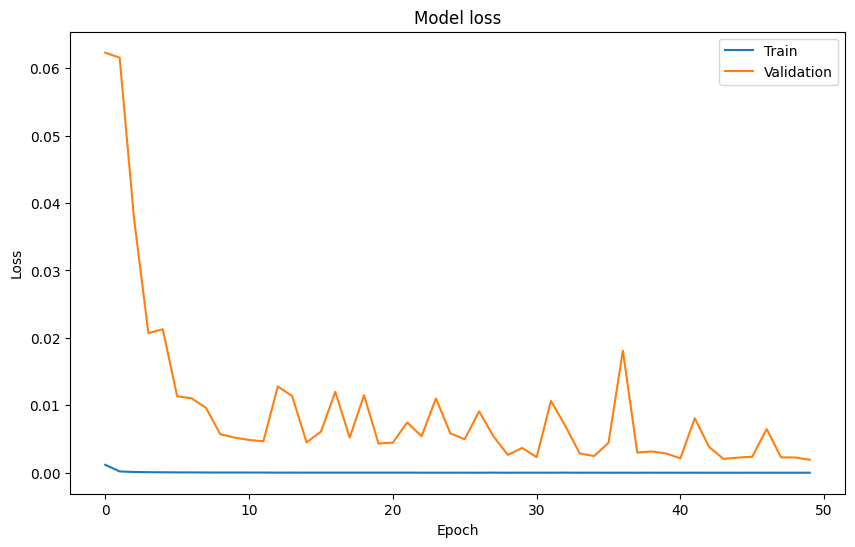

In [22]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**Hyperparameter Tuning For The LSTM model**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train Root Mean Squared Error (RMSE): 1.79
Test Root Mean Squared Error (RMSE): 2.09
Train R² Score: 0.92
Test R² Score: 0.97


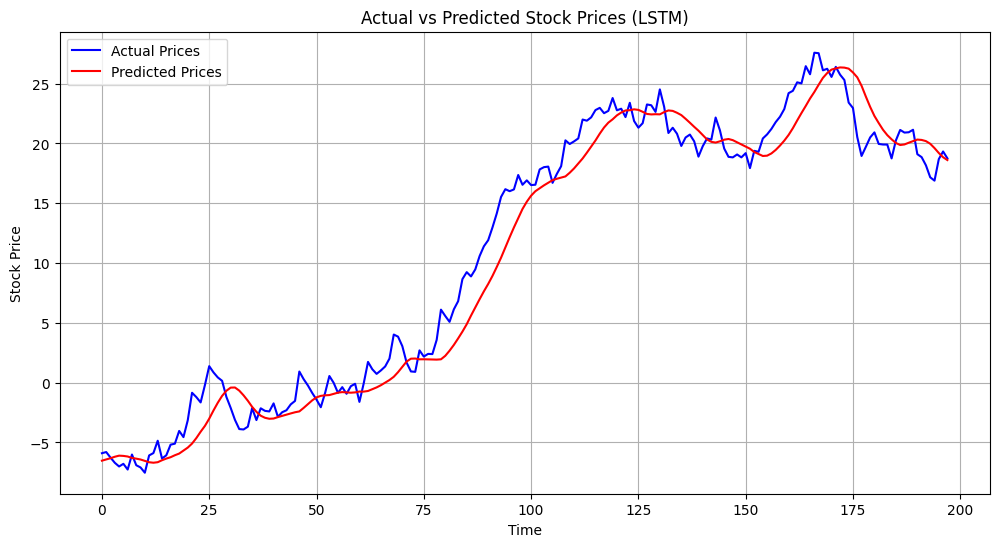

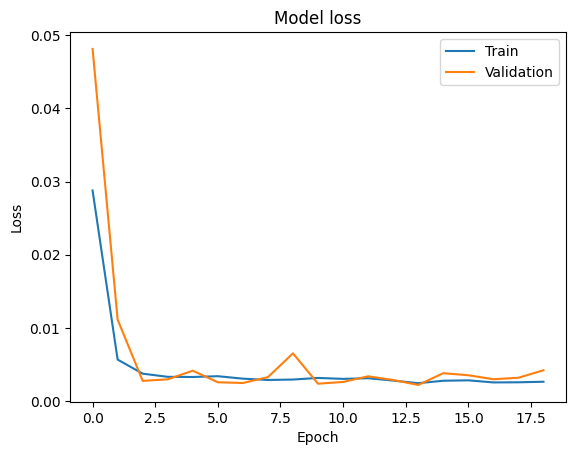

In [26]:
# Adding Sample Data (Replace with your actual data)
np.random.seed(42)
time_steps = 1000
data = np.cumsum(np.random.normal(0, 1, time_steps))
df = pd.DataFrame({'value': data})

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:] # Renamed X_val to X_test and y_val to y_test

# Improved LSTM Model
model = keras.Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(32))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

# Training with Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0) # use test data as validation during training

# Evaluation
y_train_pred_scaled = model.predict(X_train)
y_test_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values
y_train_pred = scaler.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler.inverse_transform(y_test_pred_scaled)
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

lstm_train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
lstm_test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))

lstm_train_r2 = r2_score(y_train_true, y_train_pred)
lstm_test_r2 = r2_score(y_test_true, y_test_pred)

print(f"Train Root Mean Squared Error (RMSE): {lstm_train_rmse:.2f}")
print(f"Test Root Mean Squared Error (RMSE): {lstm_test_rmse:.2f}")
print(f"Train R² Score: {lstm_train_r2:.2f}")
print(f"Test R² Score: {lstm_test_r2:.2f}")


# Plotting Actual vs. Predicted (Test Set)
plt.figure(figsize=(12, 6))
plt.plot(y_test_true, label='Actual Prices', color='blue')
plt.plot(y_test_pred, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices (LSTM)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


# Plotting the loss and validation function
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation') #Plot validation loss
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0675 - val_loss: 0.0370
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0063 - val_loss: 0.0085
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - val_l

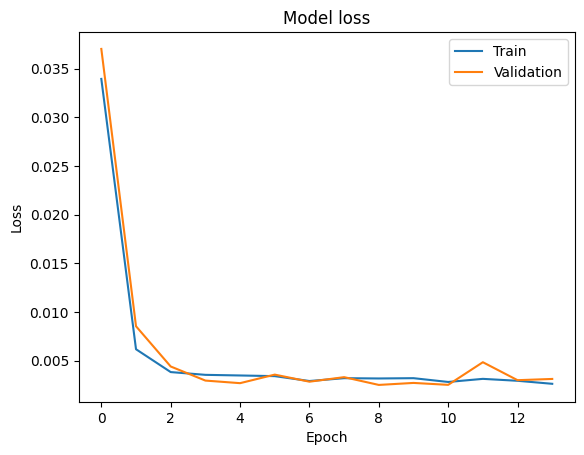

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
Predicted value: 18.902128219604492


In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Sample Data (Replace with your actual data)
# This creates a dummy time series for demonstration
np.random.seed(42)
time_steps = 1000
data = np.cumsum(np.random.normal(0, 1, time_steps))
df = pd.DataFrame({'value': data})

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Length of input sequences
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and validation sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]


# Improved LSTM Model with Overfitting Mitigation
model = keras.Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1))) # Increased units slightly
model.add(layers.Dropout(0.2)) # Dropout layer
model.add(layers.LSTM(32)) # Reduced units in the second layer
model.add(layers.Dropout(0.2)) # Another dropout layer
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

# Training with Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plotting the loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Example Prediction (Reshape for single prediction)
last_sequence = scaled_data[-seq_length:]
last_sequence = np.reshape(last_sequence, (1, seq_length, 1))
predicted_value_scaled = model.predict(last_sequence)

# Inverse transform to get the actual value
predicted_value = scaler.inverse_transform(predicted_value_scaled)
print(f"Predicted value: {predicted_value[0,0]}")

Train Root Mean Squared Error (RMSE): 1.14
Test  Root Mean Squared Error (RMSE): 17.96
Train R² Score: 0.99
Test  R² Score: 0.95


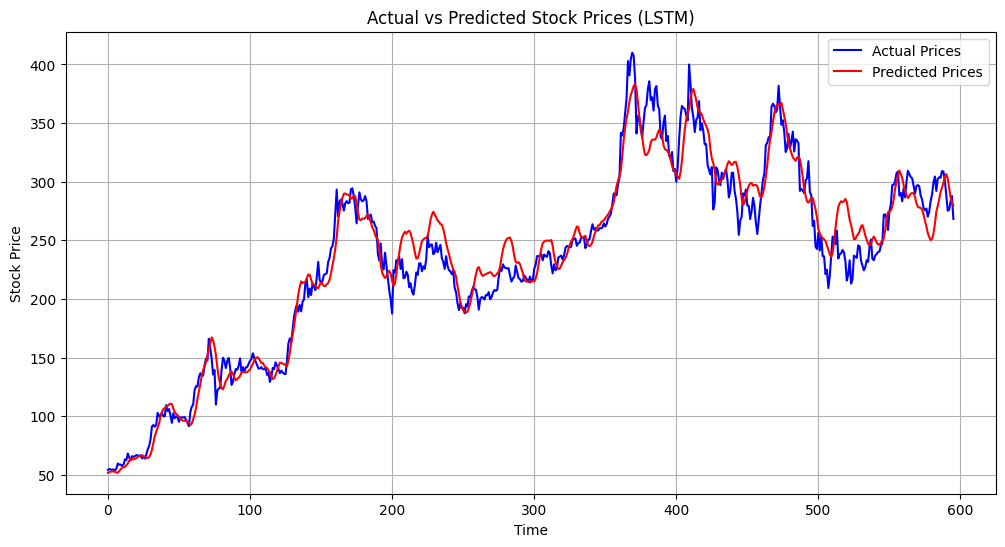

In [24]:
# Evaluation metrics
lstm_train_rmse = np.sqrt(mean_squared_error(lstm_train_actual, lstm_train_pred_actual))
lstm_test_rmse = np.sqrt(mean_squared_error(lstm_test_actual, lstm_test_pred_actual))
lstm_train_r2 = r2_score(lstm_train_actual, lstm_train_pred_actual)
lstm_test_r2 = r2_score(lstm_test_actual, lstm_test_pred_actual)

print(f"Train Root Mean Squared Error (RMSE): {lstm_train_rmse:.2f}")
print(f"Test  Root Mean Squared Error (RMSE): {lstm_test_rmse:.2f}")
print(f"Train R² Score: {lstm_train_r2:.2f}")
print(f"Test  R² Score: {lstm_test_r2:.2f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(lstm_test_actual, label='Actual Prices', color='blue')
plt.plot(lstm_test_pred_actual, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices (LSTM)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
!pip install scikit-learn==1.2.2
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin

import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd


from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define FixedXGBRegressor to handle scikit-learn compatibility
class FixedXGBRegressor(XGBRegressor):
    def __sklearn_tags__(self):
        return {
            "non_deterministic": True,
            "requires_positive_X": False,
            "requires_positive_y": False,
            "requires_y": True,
            "X_types": ["2darray"],
        }

# Ensure X_train and X_test are 2D arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
if X_train.ndim == 1:
    X_train = X_train.reshape(-1, 1)
if X_test.ndim == 1:
    X_test = X_test.reshape(-1, 1)

# Ensure y_train and y_test are 1D arrays
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()


def tune_xgb_model(X_train, y_train):
    """
    Perform hyperparameter tuning for XGBoost using GridSearchCV.
    """
    # Ensure input data is correctly shaped
    X_train = np.array(X_train)
    if X_train.ndim == 1:
        X_train = X_train.reshape(-1, 1)
    y_train = np.array(y_train).ravel()

    # Define hyperparameter grid
    param_grid = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
    }

    # Initialize XGBRegressor
    xgb_model = XGBRegressor(objective='reg:squarederror')

    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='r2',
        cv=3,
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_, grid_search.best_params_


# Call the function
best_xgb_model, best_params = tune_xgb_model(X_train, y_train)
print("Best Hyperparameters:", best_params)

def predict_and_evaluate_xgb(model, X_train, y_train, X_test, y_test, scaler_y=None):
    """
    Predict and evaluate the XGBoost model.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Inverse transform predictions if scaler_y is provided
    if scaler_y:
        y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
        y_train_pred_actual = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).ravel()
        y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
        y_test_pred_actual = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()
    else:
        y_train_actual = y_train
        y_train_pred_actual = y_train_pred
        y_test_actual = y_test
        y_test_pred_actual = y_test_pred

    # Metrics
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)

    return {
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'y_test_actual': y_test_actual,
        'y_test_pred_actual': y_test_pred_actual
    }

# Evaluate the tuned model results
xgb_tuned_results = predict_and_evaluate_xgb(
    best_xgb_model, X_train, y_train, X_test, y_test
)

# Extract and display metrics for the tuned model
print("\nPerformance of the Tuned Model:")
print(f"Train R² Score: {xgb_tuned_results['Train_R2']:.2f}")
print(f"Test R² Score: {xgb_tuned_results['Test_R2']:.2f}")

# Display actual vs predicted values for the tuned model
comparison_df_tuned = pd.DataFrame({
    'Actual': xgb_tuned_results['y_test_actual'].ravel(),
    'Predicted': xgb_tuned_results['y_test_pred_actual'].ravel()
})
print("\nActual vs Predicted (Tuned Model):")
print(comparison_df_tuned.head())

# Plot actual vs predicted values for the tuned model
plt.figure(figsize=(10, 6))
plt.plot(xgb_tuned_results['y_test_actual'], label='Actual Prices', color='blue')
plt.plot(xgb_tuned_results['y_test_pred_actual'], label='Predicted Prices (Tuned)', color='green')
plt.title('Actual vs Predicted Stock Prices (Tuned Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.


AttributeError: 'super' object has no attribute '__sklearn_tags__'

###**Hyperparameter Tuning, Feature Engineering, and Evaluation**

In [ ]:
!pip install --upgrade xgboost scikit-learn
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin

# Custom wrapper for XGBRegressor
class SklearnXGBRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.model = None

    def fit(self, X, y, **fit_params):
        self.model = XGBRegressor(**self.kwargs)
        self.model.fit(X, y, **fit_params)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def get_params(self, deep=True):
        return self.kwargs

    def set_params(self, **params):
        self.kwargs.update(params)
        return self


# Ensure X_train and X_test are 2D
X_train = np.array(X_train)
X_test = np.array(X_test)
if X_train.ndim == 1:
    X_train = X_train.reshape(-1, 1)
if X_test.ndim == 1:
    X_test = X_test.reshape(-1, 1)

# Ensure y_train and y_test are 1D
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()


# Perform hyperparameter tuning
def tune_xgb_model(X_train, y_train):
    """
    Perform hyperparameter tuning for XGBoost using GridSearchCV.

    Parameters:
    X_train (np.ndarray): Training data for features.
    y_train (np.ndarray): Training data for the target variable.

    Returns:
    SklearnXGBRegressor: Best model from the grid search.
    dict: Best hyperparameters.
    """
    # Define hyperparameter grid
    param_grid = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # Initialize wrapped XGBRegressor
    xgb_model = SklearnXGBRegressor(objective='reg:squarederror')

    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='r2',
        cv=3,
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_, grid_search.best_params_


# Perform hyperparameter tuning
best_xgb_model, best_params = tune_xgb_model(X_train, y_train)

# Evaluate the tuned model
print("Best Hyperparameters:", best_params)

# Evaluate the tuned model
print("Best Hyperparameters:", best_params)

# Evaluate the tuned model
xgb_tuned_results = predict_and_evaluate_xgb(best_xgb_model, X_train, y_train, X_test, y_test, scaler_y)

# Extract metrics for the tuned model
print("\nPerformance of the Tuned Model:")
print(f"Train R² Score: {xgb_tuned_results['Train_R2']:.2f}")
print(f"Test  R² Score: {xgb_tuned_results['Test_R2']:.2f}")

# Display actual vs predicted for the tuned model
comparison_df_tuned = pd.DataFrame({
    'Actual': xgb_tuned_results['y_test_actual'].ravel(),
    'Predicted': xgb_tuned_results['y_test_pred_actual'].ravel()
})
print("\nActual vs Predicted (Tuned Model):")
print(comparison_df_tuned.head())

# Plot actual vs predicted values for the tuned model
plt.figure(figsize=(10, 6))
plt.plot(xgb_tuned_results['y_test_actual'], label='Actual Prices', color='blue')
plt.plot(xgb_tuned_results['y_test_pred_actual'], label='Predicted Prices (Tuned)', color='green')
plt.title('Actual vs Predicted Stock Prices (Tuned Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


###**SENTIMENT DATA**

In [ ]:
# Import and mount Google Drive.
from google.colab import drive
drive.mount("/content/drive")


In [ ]:
file_path = "/content/drive/MyDrive/stock_tweets.csv"
stock_tweets = pd.read_csv(file_path)
stock_tweets.head()

In [ ]:
# Checking the data structure and summary of the sentiment data
print("Data Info:")
stock_tweets.info()

In [ ]:
# Display the basic statistical details of the sentiment data
print("\nData Description:")
stock_tweets.describe(include='all')

In [ ]:
#Checking for missing values
print("\nMissing Values:")
stock_tweets.isnull().sum()


In [ ]:
# Checking for duplicates tweets
duplicate_count = stock_tweets.duplicated().sum()
print(f"\nNumber of Duplicate Entries: {duplicate_count}")

In [ ]:
# Count stock mentions
stock_counts = stock_tweets['Stock Name'].value_counts()
print("\nMost Mentioned Stocks:")
stock_counts.head()

In [ ]:
#Convert 'Date' to datetime and extract Year, Month, Day, Hour
stock_tweets['Date'] = pd.to_datetime(stock_tweets['Date'], errors='coerce')


In [ ]:
# Visualising tweet frequncy and top most mentioned tweet of the sentiment data
plt.figure(figsize=(14, 6))

# Tweet Frequency by Year and Month
plt.subplot(1, 2, 1)
stock_tweets['Month_Year'] = stock_tweets['Date'].dt.to_period('M')
stock_tweets['Month_Year'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Tweet Frequency by Month-Year")
plt.xlabel("Month-Year")
plt.ylabel("Number of Tweets")

# Stock Mentions
plt.subplot(1, 2, 2)
sns.barplot(x=stock_counts.index[:10], y=stock_counts.values[:10], palette='viridis')
plt.title("Top 10 Most Mentioned Stocks")
plt.xlabel("Stock Name")
plt.ylabel("Number of Mentions")

plt.tight_layout()
plt.show()

In [ ]:
# We working with the TSLA tweet for this project
# Filtering the rows where the stock name is "TSLA" and create a dataframe
if 'Stock Name' in stock_tweets.columns:
    tsla_df = stock_tweets[stock_tweets['Stock Name'] == 'TSLA']
    print("\nFiltered Dataset (TSLA):")
else:
    print("\nError: Column 'Stock' does not exist in the dataset.")
tsla_df.head()


****SENTIMENT (TSLA TWEET) DATA EXPLORATORY DATA ANALYSIS****

In [ ]:
# Visualising the distribution of the TSLA tweet lenghts

tsla_df['Tweet_Length'] = tsla_df['Tweet'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(tsla_df['Tweet_Length'], kde=True, color='green', bins=20)
plt.title("Distribution of TSLA Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Visualising the TSLA tweet frequency by hour
tsla_df['Hour'] = tsla_df['Date'].dt.hour
tweet_counts_by_hour = tsla_df['Hour'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=tweet_counts_by_hour.index, y=tweet_counts_by_hour.values, palette='Blues')
plt.title("TSLA Tweet Frequency by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Tweets")
plt.show()


In [ ]:
# Visualising the TSLA tweet frequency by months of the year
tsla_df['Month_Year'] = tsla_df['Date'].dt.to_period('M')
monthly_tweet_counts = tsla_df['Month_Year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
monthly_tweet_counts.plot(kind='line', marker='o', color='orange')
plt.title("Monthly TSLA Tweet Trends")
plt.xlabel("Month-Year")
plt.ylabel("Number of Tweets")
plt.grid()
plt.show()


****PREPROCESSING THE TSLA TWEET DATA****

In [ ]:
# Downloading the NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean the tweet text
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\S+', '', tweet)  # Remove mentions
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)  # Remove non-alphabetic characters
    tweet = tweet.lower()  # Convert to lowercase
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])  # Remove stop words
    return tweet

# Clean the tweet column
tsla_df['Cleaned_Tweet'] = tsla_df['Tweet'].apply(clean_tweet)

# Check cleaned data
tsla_df[['Tweet', 'Cleaned_Tweet']].head()


In [ ]:
from transformers import pipeline as transformers_pipeline  # Import with alias

sentiment_analyzer = transformers_pipeline('sentiment-analysis')


# Load pre-trained sentiment analysis pipeline from HuggingFace
sentiment_analyzer = transformers_pipeline('sentiment-analysis')

# Function to predict sentiment for each tweet
def get_sentiment_score(tweet):
    result = sentiment_analyzer(tweet)
    return result[0]['label'], result[0]['score']

# Apply sentiment analysis to the cleaned tweets
tsla_df[['Sentiment', 'Sentiment_Score']] = tsla_df['Cleaned_Tweet'].apply(lambda x: pd.Series(get_sentiment_score(x)))

# Check the results
tsla_df[['Cleaned_Tweet', 'Sentiment', 'Sentiment_Score']].head()


In [ ]:
# Feature engineering: tweet length, number of hashtags, mentions, and sentiment scores
tsla_df['Tweet_Length'] = tsla_df['Cleaned_Tweet'].apply(len)
tsla_df['Num_Hashtags'] = tsla_df['Tweet'].apply(lambda x: len(re.findall(r'#\w+', x)))
tsla_df['Num_Mentions'] = tsla_df['Tweet'].apply(lambda x: len(re.findall(r'@\w+', x)))

# Group by date and aggregate sentiment scores for daily features
tsla_df['Date'] = tsla_df['Date'].dt.date  # Convert to date only
daily_sentiment = tsla_df.groupby('Date').agg(
    avg_sentiment_score=('Sentiment_Score', 'mean'),
    total_tweets=('Sentiment', 'count'),
    avg_tweet_length=('Tweet_Length', 'mean'),
    avg_num_hashtags=('Num_Hashtags', 'mean'),
    avg_num_mentions=('Num_Mentions', 'mean')
).reset_index()

# Check aggregated data
daily_sentiment.head()


****FEATURE ENGINEERING****

In [ ]:
# Ensure 'Date' is a column, not an index
if 'Date' not in stock_data.columns:
    stock_data = stock_data.reset_index()  # Reset index to move 'Date' back to a column

if 'Date' not in daily_sentiment.columns:
    daily_sentiment = daily_sentiment.reset_index()

# Convert 'Date' columns in both DataFrames to the same format
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date  # Convert to datetime.date
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date']).dt.date

# Merge stock data with daily sentiment data
data = pd.merge(stock_data, daily_sentiment, on='Date', how='inner')

# Check the merged data
data.head()


In [ ]:
data.describe()

In [ ]:
data.isnull().sum()

In [ ]:
data.shape

In [ ]:
# Feature Engineering and Scaling
feature_columns = data.columns.difference(['Date', 'Close'])
target_column = 'Close'

# Handle missing values (if any)
data = data.dropna()

# Split features and target
X = data[feature_columns]
y = data[target_column]

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scalers to the data
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

In [ ]:
# --- Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

# Evaluate
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_test_pred))
lr_r2 = r2_score(y_test, lr_test_pred)  # Calculate R² score

print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Linear Regression R²: {lr_r2}")

In [ ]:
# --- XGBoost ---
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

# Evaluate
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))
xgb_r2 = r2_score(y_test, xgb_test_pred)  # Calculate R² score

print(f"XGBoost RMSE: {xgb_rmse}")
print(f"XGBoost R²: {xgb_r2}")

In [ ]:
# --- LSTM ---
# Reshape data for LSTM (3D input: samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)

# Predictions
lstm_train_pred = lstm_model.predict(X_train_lstm)
lstm_test_pred = lstm_model.predict(X_test_lstm)

# Evaluate
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_test_pred))
lstm_r2 = r2_score(y_test, lstm_test_pred)  # Calculate R² score

print(f"LSTM RMSE: {lstm_rmse}")
print(f"LSTM R²: {lstm_r2}")

In [ ]:
from tensorflow.keras.models import save_model
import joblib  # Correct import for saving Scikit-learn models

# Define file paths
lstm_model_path = 'model_lstm.keras'
xgb_model_path = 'model_xgb.json'
linear_model_path = 'model_linear.pkl'

# Save the LSTM model
save_model(lstm_model, lstm_model_path)
print(f"LSTM model saved as '{lstm_model_path}'")

# Save the XGBoost model
xgb_model.save_model(xgb_model_path)
print(f"XGBoost model saved as '{xgb_model_path}'")

# Save the Linear Regression model
joblib.dump(linear_model, linear_model_path)
print(f"Linear Regression model saved as '{linear_model_path}'")



In [ ]:
# Load the saved models
def load_saved_models():
    """
    Load the saved models from disk.

    Returns:
    tuple: A tuple containing the loaded LSTM, XGBoost, and Linear Regression models.
    """
    # Load the LSTM model
    lstm_model = load_model('model_lstm.keras')
    print("LSTM model loaded successfully.")

    # Load the XGBoost model
    xgb_model = xgb.Booster()
    xgb_model.load_model('model_xgb.json')
    print("XGBoost model loaded successfully.")

    # Load the Linear Regression model
    linear_model = joblib.load('model_linear.pkl')
    print("Linear Regression model loaded successfully.")

    return lstm_model, xgb_model, linear_model

In [ ]:
from tensorflow.keras.models import load_model

def load_models():
    """
    Load the saved models from disk.

    Returns:
    tuple: A tuple containing the loaded LSTM, XGBoost, and Linear Regression models.
    """
    # Load the LSTM model
    model_lstm = load_model('model_lstm.keras')
    print("LSTM model loaded successfully.")

    # Load the XGBoost model
    model_xgb = xgb.Booster()
    model_xgb.load_model('model_xgb.json')
    print("XGBoost model loaded successfully.")

    # Load the Linear Regression model
    model_linear = joblib.load('model_linear.pkl')
    print("Linear Regression model loaded successfully.")

    return model_lstm, model_xgb, model_linear

# Call the function to load models
model_lstm, model_xgb, model_linear = load_models()


In [ ]:
# Load the saved models
from tensorflow.keras.models import load_model

def load_models():
    """
    Load the saved models from disk.

    Returns:
    tuple: A tuple containing the loaded LSTM, XGBoost, and Linear Regression models.
    """
    # Load the LSTM model
    model_lstm = load_model('model_lstm.keras')
    print("LSTM model loaded successfully.")

    # Load the XGBoost model
    model_xgb = xgb.Booster()
    model_xgb.load_model('model_xgb.json')
    print("XGBoost model loaded successfully.")

    # Load the Linear Regression model
    model_linear = joblib.load('model_linear.pkl')
    print("Linear Regression model loaded successfully.")

    return model_lstm, model_xgb, model_linear

# Load the saved models
model_lstm, model_xgb, model_linear = load_models()

In [ ]:
import xgboost as xgb
from xgboost import DMatrix  # Import DMatrix
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler


def predict_and_evaluate(model, X_test_original, y_test, scaler_y, model_name):
    """
    Predict and evaluate the performance of a regression model.

    Parameters:
    model: Trained model to use for predictions.
    X_test_original: Original, unscaled test features.
    y_test: Scaled true target values.
    scaler_y: Scaler used for target variable transformation.
    model_name: Name of the model.

    Returns:
    dict: Evaluation metrics.
    """
    look_back = 30  # Adjust look_back to a feasible value

    if model_name == "XGBoost":
        # Convert X_test to DMatrix
        X_test_dmatrix = DMatrix(X_test_original.reshape(X_test_original.shape[0], -1))  # Reshape for XGBoost
        y_pred = model.predict(X_test_dmatrix)
    elif model_name == "LSTM":
        if X_test_original.shape[0] < look_back:
            raise ValueError(f"Not enough data points in X_test_original for look_back period of {look_back}. "
                             f"X_test_original has {X_test_original.shape[0]} data points.")

        # Prepare LSTM test data
        num_samples = X_test_original.shape[0] - look_back + 1
        X_test_reshaped = np.zeros((num_samples, look_back, X_test_original.shape[1]))
        for i in range(num_samples):
            X_test_reshaped[i] = X_test_original[i:i + look_back]

        y_pred = model.predict(X_test_reshaped)
    else:  # Linear Regression
        # Select the original features used during training
        original_features = [col for col in stock_data.columns if col not in ['Date', 'Close']]  # Replace with your actual feature names

        # Ensure X_test has the same features as during training
        if X_test_original.shape[1] != len(original_features):  # Check if the number of features matches
            X_test_lr = X_test_original[:, :len(original_features)]  # Select relevant features for Linear Regression
        else:
            X_test_lr = X_test_original  # Already matches the feature count

        # Ensure X_test is 2D for Linear Regression
        X_test_lr = X_test_lr.reshape(X_test_lr.shape[0], -1)  # Flatten if required (though it should already be 2D)

        y_pred = model.predict(X_test_lr)

    # Reshape y_test to 2D for inverse_transform
    y_test = y_test.reshape(-1, 1)

    # Inverse transform predictions and actual values
    y_test_actual = scaler_y.inverse_transform(y_test)
    y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

    # Evaluate metrics
    metrics = evaluate_model(y_test_actual, y_pred_actual, model_name)
    return metrics

# Evaluate LSTM
try:
    lstm_metrics = predict_and_evaluate(model_lstm, X_test, y_test, scaler_y, "LSTM")
except ValueError as e:
    print(f"Error in LSTM evaluation: {e}")
    lstm_metrics = None

# Evaluate XGBoost
try:
    xgb_metrics = predict_and_evaluate(model_xgb, X_test, y_test, scaler_y, "XGBoost")
except ValueError as e:
    print(f"Error in XGBoost evaluation: {e}")
    xgb_metrics = None

# Evaluate Linear Regression
try:
    linear_metrics = predict_and_evaluate(model_linear, X_test, y_test, scaler_y, "Linear Regression")
except ValueError as e:
    print(f"Error in Linear Regression evaluation: {e}")
    linear_metrics = None

# Combine all metrics into a DataFrame and display
all_metrics = pd.DataFrame([m for m in [lstm_metrics, xgb_metrics, linear_metrics] if m is not None])
print(all_metrics)




In [ ]:
# Evaluate Linear Regression
try:
    linear_metrics = predict_and_evaluate(model_linear, X_test, y_test, scaler_y, "Linear Regression")
except ValueError as e:
    print(f"Error in Linear Regression evaluation: {e}")
    linear_metrics = None

# Combine all metrics into a DataFrame and display
all_metrics = pd.DataFrame([m for m in [lstm_metrics, xgb_metrics, linear_metrics] if m is not None])
print(all_metrics)

In [ ]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).

    Parameters:
    y_true (array-like): True target values.
    y_pred (array-like): Predicted target values.

    Returns:
    float: The MAPE value.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate and return evaluation metrics for the models
def evaluate_model(y_true, y_pred, model_name):
    """
    Calculate and return evaluation metrics for a regression model.

    Parameters:
    y_true (array-like): True target values.
    y_pred (array-like): Predicted target values.
    model_name (str): The name of the model being evaluated.

    Returns:
    dict: A dictionary containing the evaluation metrics.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    metrics = {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }

    return metrics

# Evaluate models
lstm_metrics = evaluate_model(y_test_actual_lstm, y_pred_actual_lstm, "LSTM")
xgb_metrics = evaluate_model(y_test_actual_xgb, y_pred_actual_xgb, "XGBoost")
linear_metrics = evaluate_model(y_test_actual_linear, y_pred_actual_linear, "Linear Regression")

# Combine all metrics into a DataFrame and display
all_metrics = pd.DataFrame([lstm_metrics, xgb_metrics, linear_metrics])
print(all_metrics)


In [ ]:
# --- Results ---
# Inverse transform predictions to original scale
lr_test_pred_actual = scaler_y.inverse_transform(lr_test_pred)
xgb_test_pred_actual = scaler_y.inverse_transform(xgb_test_pred.reshape(-1, 1))
lstm_test_pred_actual = scaler_y.inverse_transform(lstm_test_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

# Plot actual vs predicted
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(lr_test_pred_actual, label='Linear Regression Predictions', color='green')
plt.plot(xgb_test_pred_actual, label='XGBoost Predictions', color='orange')
plt.plot(lstm_test_pred_actual, label='LSTM Predictions', color='red')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()